# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

torch.set_grad_enabled(False)

In [5]:

from src.consts import FILTERATIONS
from src.datasets.download_dataset import load_splitted_counter_fact
from tqdm import tqdm
from src.types import MODEL_ARCH
from src.models.model_interface import get_model_interface


/home/yandex/DL20232024a/nirendy/repos/ADL_2/venv/lib/python3.12/site-packages/mamba_ssm/ops/selective_scan_interface.py:163: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/yandex/DL20232024a/nirendy/repos/ADL_2/venv/lib/python3.12/site-packages/mamba_ssm/ops/selective_scan_interface.py:239: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/yandex/DL20232024a/nirendy/repos/ADL_2/venv/lib/python3.12/site-packages/mamba_ssm/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/yandex/DL20232024a/nirendy/repos/ADL_2/venv/lib/python3.12/site-packages/mamba_ssm/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)

In [3]:
# device = "cuda"
# model_name = "state-spaces/mamba2-1.3b"
seed = 0
n_layers = 48

In [4]:
# Uncomment below to set correct caching directories

# hf_dir = XXX
# tri_dir = YYY
# xdg_dir = ZZZ
# os.environ['HF_HOME'] = hf_dir
# os.environ['TRITON_CACHE_DIR'] = tri_dir
# os.environ['XDG_CACHE_HOME'] = xdg_dir

# Prep Data

In [6]:
original_res = pd.read_parquet('entire_results_original.parquet')
attn_res = pd.read_parquet('entire_results_attention.parquet')
mask = (original_res['hit'] == attn_res['hit']) & (attn_res['hit'] == True)
data = attn_res[mask].reset_index(drop=True)

# Analysis Functionality

In [7]:
model_arch = MODEL_ARCH.MINIMAL_MAMBA2_new
model_interface = get_model_interface(model_arch, model_size="130M")

In [16]:
torch.random.manual_seed(seed)
# model.eval()
temperature = 1
top_k = 0
top_p = 1

In [8]:
tokenizer = model_interface.tokenizer
device = model_interface.device

In [9]:
# Taken from https://github.com/google-research/google-research/blob/master/dissecting_factual_predictions/utils.py 
def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]

def find_token_range(tokenizer, token_array, substring):
    """Find the tokens corresponding to the given substring in token_array."""
    toks = decode_tokens(tokenizer, token_array)
    whole_string = "".join(toks)
    char_loc = whole_string.index(substring)
    loc = 0
    tok_start, tok_end = None, None
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(substring):
            tok_end = i + 1
            break
    return (tok_start, tok_end)

In [21]:
def forward_eval(temperature, top_k, top_p, prompt_idx, window):
    prompt = data.loc[prompt_idx, 'prompt']
    true_word = data.loc[prompt_idx, 'target_true']
    true_token = tokenizer(true_word, return_tensors="pt", padding=True)
    true_id = true_token.input_ids.to(device='cpu')
    tokens = tokenizer(prompt, return_tensors="pt", padding=True)
    input_ids = tokens.input_ids.to(device=device)
    max_new_length = input_ids.shape[1] + 1
    last_idx = input_ids.shape[1] - 1
    probs = np.zeros((input_ids.shape[1]))

    for idx in range(input_ids.shape[1]):
        num_to_masks = {layer : [(last_idx, idx)] for layer in window}
        
        next_token_probs = model_interface.generate_logits(
            input_ids=input_ids,
            attention=True,
            num_to_masks=num_to_masks,
        )
        probs[idx] = next_token_probs[0, true_id[:, 0]]
        torch.cuda.empty_cache()
    return probs

In [22]:
def evaluate(temperature, top_k, top_p, prompt_indices, windows):
    for prompt_idx in prompt_indices:
        prob_mat = []
        for window in windows:
            prob_mat.append(forward_eval(temperature, top_k, top_p, prompt_idx, window))
        prob_mat = np.array(prob_mat).T
        prompt = data.loc[prompt_idx, 'prompt']
        true_word = data.loc[prompt_idx, 'target_true']
        base_prob = data.loc[prompt_idx, 'true_prob']
        tokens = tokenizer(prompt, return_tensors="pt", padding=True)
        input_ids = tokens.input_ids.to(device=device)
        toks = decode_tokens(tokenizer, input_ids[0]) 
        last_tok = toks[-1]
        toks[-1] = toks[-1] + '*'

        fontsize = 8
        plt.figure(figsize=(4, 3))
        ax = sns.heatmap(prob_mat, cmap="Purples_r", cbar=True)
        plt.title(f'Intervening on flow to:' + last_tok + f'\nwindow: {len(windows[0])}, base probability: {round(base_prob, 4)}', 
                  fontsize=fontsize)
        plt.xlabel('')
        plt.ylabel('')
        x_pos = list(range(0, prob_mat.shape[1], 5))
        plt.xticks(ticks=np.array(range(0, prob_mat.shape[1], 5)) + 0.5, labels=[str(x) for x in x_pos], 
                   rotation=0, fontsize=fontsize)
        plt.yticks(ticks=np.arange(prob_mat.shape[0]) + 0.5, labels=toks, rotation=0, fontsize=fontsize)
        ax.tick_params(axis='both', which='both', length=0)
        cbar = ax.collections[0].colorbar
        cbar.ax.set_xlabel(f'p({true_word[1:]})', labelpad=10, fontsize=fontsize)
        cbar.locator = plt.MaxNLocator(nbins=5)
        cbar.update_ticks()
        cbar.ax.tick_params(labelsize=fontsize)
        plt.tight_layout()
        plt.savefig(f'heatmap_idx={prompt_idx}_ws={window_size}.pdf', format="pdf")
        plt.show()

# Experiments

In [23]:
print("The following prompts are used in [Geva et al. 23'] and are ones for which our core model is correct:")
print('Commerzbank, whose headquarters are in')
print('Edvard Grieg, playing the')
print('Statistical Package for the Social Sciences was created by')
print('The mother tongue of Pietro Mennea is')

The following prompts are used in [Geva et al. 23'] and are ones for which our core model is correct:
Commerzbank, whose headquarters are in
Edvard Grieg, playing the
Statistical Package for the Social Sciences was created by
The mother tongue of Pietro Mennea is


In [24]:
# prompt_indices = [2841, 661, 3124, 2274]
# window_size = 5
# windows = [list(range(i, i + window_size)) for i in range(0, n_layers - window_size + 1)]

In [25]:
prompt_indices = [1,2,3,4]
window_size = 5
windows = [list(range(i, i + window_size)) for i in range(0, n_layers - window_size + 1)]

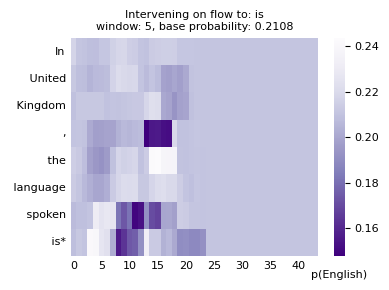

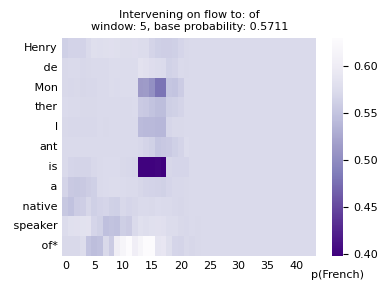

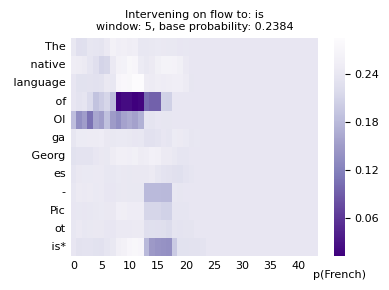

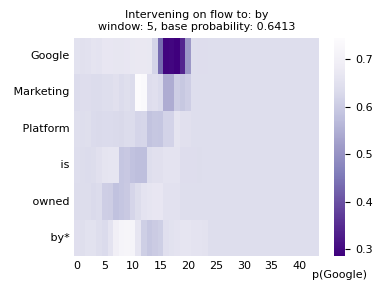

In [26]:
evaluate(temperature, top_k, top_p, prompt_indices, windows)